In [1]:
import sys

sys.path.append('../src')

In [2]:
import numpy as np
from tnsgrt.structure import Structure

nodes = np.array([[0,0,0], [0,1,0], [1,1,0], [1,0,0]]).transpose()
members = np.array([[0,1], [1,2], [2,3], [3,0], [0,2], [1,3]]).transpose()
s1 = Structure(nodes, members, number_of_strings=4)
s = s1.merge(s1.copy().translate(np.array([1,0,0])))
s.add_member_tag('tag', [6, 7])
s

Structure with 8 nodes, 4 bars and 8 strings

In [3]:
s.merge_close_nodes()
s

Structure with 6 nodes, 4 bars and 8 strings

In [5]:
s.merge_overlapping_members(verbose=True)
s, s.member_tags

(Structure with 6 nodes, 4 bars and 7 strings,
 {'bar': array([ 4,  5,  9, 10]),
  'string': array([0, 1, 2, 3, 6, 7, 8]),
  'tag': array([2, 6])})

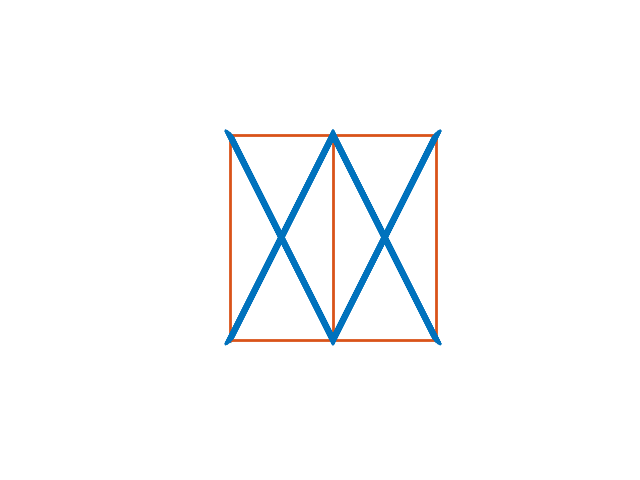

In [5]:
from matplotlib import pyplot as plt
from tnsgrt.plotter.matplotlib import MatplotlibPlotter
%matplotlib widget

plotter = MatplotlibPlotter()
plotter.plot(s)
fig, ax = plotter.get_handles()
ax.view_init(90,-90)
ax.axis('off')
plt.show()

In [28]:
self = s.copy()
# sort members
sorted_members = np.sort(self.members, axis=0)
unique_members, unique_indices, unique_inverse, unique_counts = \
    np.unique(sorted_members, axis=1, return_index=True, return_inverse=True, return_counts=True)
# select members that appear more than once
repeated_members = unique_indices[unique_counts > 1]

In [29]:
sorted_members, unique_members, unique_indices, unique_inverse, unique_counts

(array([[0, 1, 2, 0, 0, 1, 2, 2, 4, 3, 3, 2],
        [1, 2, 3, 3, 2, 3, 3, 4, 5, 5, 4, 5]]),
 array([[0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4],
        [1, 2, 3, 2, 3, 3, 4, 5, 4, 5, 5]]),
 array([ 0,  4,  3,  1,  5,  2,  7, 11, 10,  9,  8], dtype=int64),
 array([ 0,  3,  5,  2,  1,  4,  5,  6, 10,  9,  8,  7], dtype=int64),
 array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int64))

In [30]:
members_to_be_removed = []
tags_to_be_added = {}
for member_idx in unique_inverse[repeated_members]:
    # find repeated members
    repeated = np.nonzero(unique_inverse == member_idx)[0]
    print(member_idx)
    print(repeated)
    # merge member properties
    self.member_properties.loc[repeated[0], ['force', 'lambda_']] = self.member_properties.loc[repeated, ['force', 'lambda_']].sum()
    # merge member tags
    existing_tags = set(self.get_member_tags(repeated[0]))
    repeated_tags = set(*[self.get_member_tags(j) for j in repeated[1:]])
    new_tags = repeated_tags - existing_tags
    # TODO: warn of change of sign
    tags_to_be_added[repeated[0]] = new_tags
    print(existing_tags, repeated_tags, new_tags)
    print(tags_to_be_added)
    # which members to remove?
    members_to_be_removed.extend(repeated[1:])
    print(members_to_be_removed)

5
[2 6]
{'string'} {'tag', 'string'} {'tag'}
{2: {'tag'}}
[6]


In [31]:
import collections

# invert tag map
inv_tag_map = collections.defaultdict(list)
for member, tags in tags_to_be_added.items():
    for tag in tags:
        inv_tag_map[tag].append(member)
print(inv_tag_map)
# add tags
for tag, members in inv_tag_map.items():
    self.add_member_tag(tag, members)
# remove members
if members_to_be_removed:
    self.remove_members(members_to_be_removed)
self.member_tags

defaultdict(<class 'list'>, {'tag': [2]})


{'bar': array([ 4,  5,  9, 10]),
 'string': array([0, 1, 2, 3, 6, 7, 8]),
 'tag': array([2, 6])}

array([0, 1, 2, 3, 0, 1, 1, 2, 3, 0, 2, 3])